# Assignment 2 : Exercise on T-SNE visualization of Amazon Fine Food Reviews:

In [56]:
#To remove all warning 
import warnings
warnings.filterwarnings('ignore')

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords 
import string
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

In [84]:
#Loading the Amazon Fine Food Reviews Dataset
ori_data = pd.read_csv("Reviews1.csv")

print("Original Shape of data:",ori_data.shape)

#Structure of 5 rows of data
ori_data.head()

Original Shape of data: (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


** observation:** By seeing shape of original data, it consists of 568454 rows and 10 attributes.

In [85]:
#Giving the summary of dataframe

ori_data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [86]:
ori_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568428 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [87]:
#Seeing the null values for each column.
ori_data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   26
Text                       0
dtype: int64

For ProfileName consisting of 16 NaN values and Summary Column has 26 NaN values.

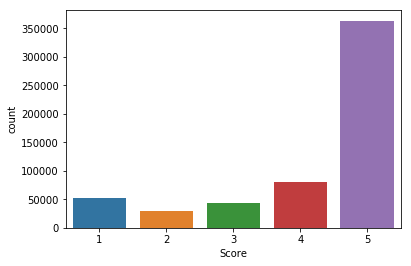

5    0.638789
4    0.141885
1    0.091948
3    0.075010
2    0.052368
Name: Score, dtype: float64

In [88]:
#Showing the counts of each category in bars
sns.countplot(x=ori_data['Score'], data=ori_data)
plt.show()

#counts of each category values in Score attribute
ori_data['Score'].value_counts(normalize=True)

By seeing all review ratings, 63.8% of ratings are with 5.

In [89]:
#Removing score rating is equal to 3.
ori_data = ori_data[ori_data['Score'] != 3]
ori_data.shape

(525814, 10)

In [90]:
#Making positive review for Score values > 3 and negative  review for Score value < 3.
ori_data['Score'] = ['positive' if(score>3) else 'negative' for score in ori_data['Score']]

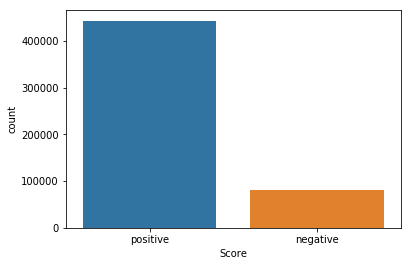

positive    0.843981
negative    0.156019
Name: Score, dtype: float64

In [91]:
#plot for positive and negative reviews.
sns.countplot(x=ori_data['Score'], data=ori_data)
plt.show()

#positive review and negative review percentages.
ori_data['Score'].value_counts(normalize=True)

** observation:** Among all reviews 84.3% are the positive reviews and 15.7% are the negative reviews.

## Data Cleaning:

** Removing Duplication Entries:**

In [92]:
#Sorting values based on the productId attribute
ori_data = ori_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [93]:
ori_data = ori_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
#After removing duplicates then our shape of data
print("Shape of the data after removal of duplicates:", ori_data.shape)

Shape of the data after removal of duplicates: (364173, 10)


** Storing only Helpfullness Numerator Greater than Helpfullness Denominator: **

In [94]:
ori_data = ori_data[ori_data['HelpfulnessNumerator'] <= ori_data['HelpfulnessDenominator']]
print("Shape of data after helpfullness numerator <= helpfullness denominator", ori_data.shape)

Shape of data after helpfullness numerator <= helpfullness denominator (364171, 10)


In [97]:
#calculating positive reviews and negative reviews
ori_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

** After completing Data cleaning we have 307061 positive reviews and 57110 negative reviews. **

## Text Preprocessing: 

#### 1. Removal of HTML Tags.

#### 2. Removal of Special characters.

#### 3. Converting texts into Small characters.

#### 4. Removing Stopwords.

#### 5. Stemming with porter stemming.

In [140]:
#set of stopwords
stop_words = set(stopwords.words('english'))

#stemming using porter stemming
sno = nltk.stem.SnowballStemmer('english')

#Function for removal of html tags
def cleanhtml(sentence):
    text = re.sub("<.*?>", '', sentence)
    return text

#Function for removing punctuations
def cleanpunc(sentence):
    text = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    text = re.sub(r'[.|,|)|(|\|/]',r' ',text)
    return text

In [144]:

%%time

#Doing Text preprocessing steps  for Text column in the data

#Assigning empty list of preprocess_text because to store all  preprocessed texts.
preprocess_text = []
row = 0

for sent in ori_data['Text']:
    
    #Assigning pre_sent to store each preprocessed text
    pre_sent = []
    
    #Removing all html tags in each sentence
    sent = cleanhtml(sent)
    for word in sent.split():
       # print(cleanpunc(word).split())
        for cleanword in cleanpunc(word).split(): #Removing all punctuations
            
            #cleanedword should be characters and lengh of each word should be greater than 2
            if((cleanword.isalpha()) & (len(cleanword)>2)):
                
                #Converting cleanword to lowercase and cleaned word should not be an stopword
                if(cleanword.lower() not in stop_words):
                    
                    #applying stemming on cleanword
                    final_word = (sno.stem(cleanword.lower())).encode('utf8')
                    pre_sent.append(final_word)
                else:
                    continue
            else:
                continue
    str = b' '.join(pre_sent).decode('utf8')
    preprocess_text.append(str)
    
    if row % 10000 == 0:
        print(row,end='\r') #overwritting the row number
    row += 1

Wall time: 15min 46s


In [151]:
#Creating one more into data which is an CleanedText
ori_data['CleanedText'] = preprocess_text

In [153]:
#Now shape of the data
print("Shape of data after adding cleanedtext",ori_data.shape)

#Top 5 rows of ori_data
ori_data.head()

Shape of data after adding cleanedtext (364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
515425,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
24750,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
24749,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
308076,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...,book easi read ingredi avail store unlik recip...
150523,150524,6641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


In [154]:
# Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
   pickle.dump(obj,open(filename,"wb"))


def openfromfile(filename):
   temp = pickle.load(open(filename,"rb"))
   return temp

In [155]:
#Saving the ori_data as new_amazon_prepocess_data
savetofile(ori_data,"New_Amazon_preprocess_data")

In [229]:
#opening the file
ori_data = openfromfile("New_Amazon_preprocess_data")

In [230]:
#Sorting the data based on the time
#ori_data.sort_values('Time', inplace=True)

#reseting the index
ori_data = ori_data.reset_index(drop=True)
ori_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
1,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
2,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
3,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...,book easi read ingredi avail store unlik recip...
4,150524,6641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


In [219]:
#Storing all positive reviews into pos
pos = ori_data[ori_data.Score == 'positive']
#Storing all negative reviews into neg
neg = ori_data[ori_data.Score == 'negative']
print(pos.shape, neg.shape)

(307061, 11) (57110, 11)


In [252]:
#Reducing my data size to 500  positive reviews and 500 negative reviews, so now total data set size 1000 reviews data
p1 = pos.head(500)
n1 = neg.head(500)
print(p1.shape,n1.shape)
frames=[p1,n1]
pn = pd.concat(frames)
print(pn.shape)

(500, 11) (500, 11)
(1000, 11)


In [253]:
#Storing x1 as text feature and y1(label) as Score feature
X = pn['CleanedText']
y = pn['Score']
print("shape of X:",X.shape)
print("shape of y:",y.shape)

shape of X: (1000,)
shape of y: (1000,)


In [254]:
# #Taking first 1000 rows
# ori_data_1000 = ori_data.head(1000)

In [255]:
# #Storing CleanedText attribute into X and Score attribute into Y
# X = ori_data_1000['CleanedText']
# y = ori_data_1000['Score']

## BOW:
  which means makes a vector for each review of length unique words from the whole dataset and makes frequency count of word.

In [256]:
count_vec = CountVectorizer()
#which can return the sparse matrix
bow = count_vec.fit_transform(X)

In [257]:
#Converting Sparse matrix to dense matrix
bow = bow.todense()

**TSNE:** t-distributed Stochastic Neighbor Embedding
        
        1. TSNE should preserve the local structure of the data, but PCA should preserve global structure of data.
        2. Neighbourhood  means nearest  points to mainpoint.
        3. Embedding means converting a  point which is in high dimension to same point into  low dimension.
        4. It can preserve distances of neighbourhood points, but cann't preserve points which are  furthur to neighborhood.
        5. It has some problem is Crowding problem.
        6. TSNE consisting of  two parameters are: 1) step and 2) perplexity.
        7. step means number of iterations as the number of iterations increases then better the solution.
        8. perplexity means number of nearest neighbours, run for multiple perplexity values as 2<=p<=n.
        9. TSNE is non-deterministic algorithm which means changes the shape at every time.
        10. It can preserve distances between the clusters.

** 1.perplexity = 30 and no.of.iterations=1000**

In [258]:

%%time

#Running tsne with the default parameters are n_iterations=1000, perplexity=30 
bow_tsne = TSNE().fit_transform(bow)

Wall time: 1min 27s


In [259]:
#Function for tsne plot

def tsne_plot(x_data, y_label):
    #Splitting the array into lists of multiple sub-arrays of vertically.
    tsne = np.vstack((x_data.T, y_label)).T
    #Froming the dataframe with data and columns
    tsne_dataframe = pd.DataFrame(data=tsne, columns=('Dim_1', 'Dim_2', 'Score'))
    sns.FacetGrid(bow_tsne_dataframe,hue='Score',size=6).map(plt.scatter,'Dim_1','Dim_2').add_legend()  
    plt.show()

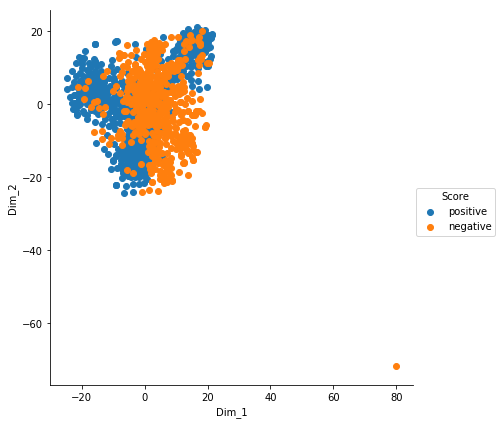

In [260]:
#Calling the function to plot for tsne 
tsne_plot(bow_tsne, y)

**2.perplexity=40 and no.of.iterations=500**

In [261]:

%%time

#Running tsne with the default parameters are n_iterations=500, perplexity=40 
bow_tsne = TSNE(perplexity=40, n_iter=500).fit_transform(bow)

Wall time: 1min 18s


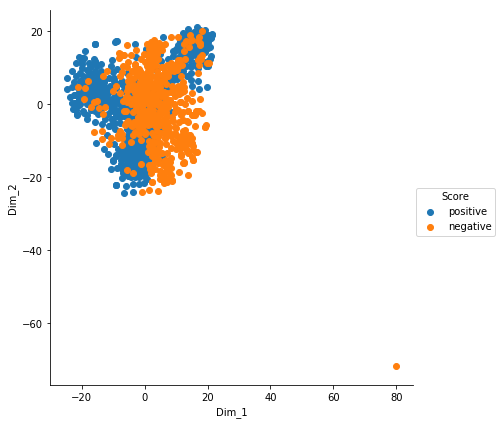

In [262]:
#Calling the function to plot for tsne 
tsne_plot(bow_tsne, y)

**3.perplexity=20 and no.of.iterations=5000**

In [263]:

%%time

#Running tsne with the default parameters are n_iterations=500, perplexity=40 
bow_tsne = TSNE(perplexity=20, n_iter=5000).fit_transform(bow)

Wall time: 2min 44s


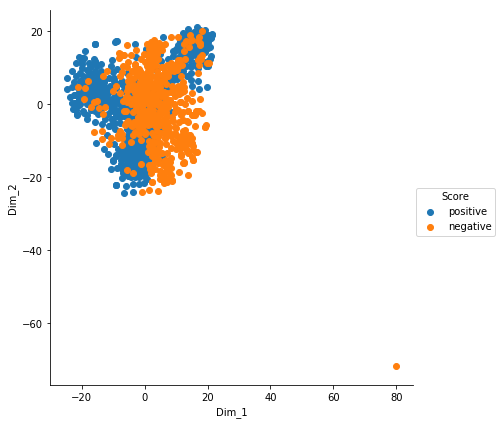

In [264]:
#Calling the function to plot for tsne 
tsne_plot(bow_tsne, y)

## TF-IDF:

TF-IDF stands for term frequency-inverse document frequency. TF-IDF weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.

Term_frequency(TF) = (number of times word occur in document) / (Total number of words in the document).

Inverse_Document_freqency(IDF) = log((total number of documents) / In which documents a word occurs))

                   So, TF-IDF(word) = TF(wor) * IDF(word)

In [265]:
#Vectorizing the data
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf = tfidf_vect.fit_transform(X)

In [266]:
#Converting Sparse vector to Dense vector
tfidf = tfidf.todense()

**perplexity=30 and number of iterations=1000**

In [267]:
#Running tsne with the default parameters are n_iterations=1000, perplexity=30
tfidf_tsne = TSNE().fit_transform(tfidf)

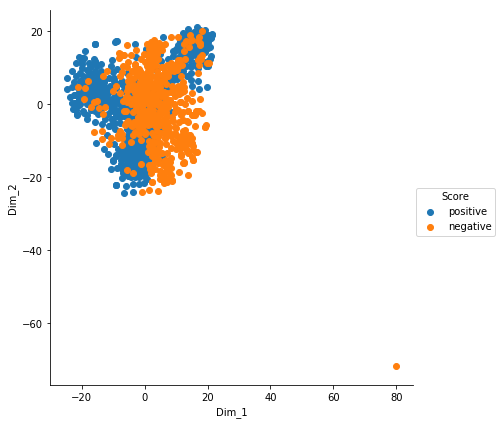

In [268]:
#Calling the function to plot for tsne 
tsne_plot(tfidf_tsne, y)

**perplexity=40 and no.of.iterations=2000**

In [269]:
#Running tsne with the default parameters are n_iterations=2000, perplexity=40
tfidf_tsne = TSNE(perplexity=40, n_iter=2000).fit_transform(tfidf)

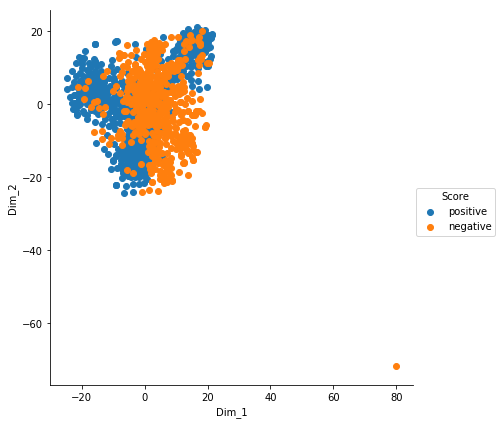

In [270]:
#Calling the function  to plot for tsne
tsne_plot(tfidf_tsne, y)

**perplexity=20 and no.of.iterations=5000**

In [271]:
#Running tsne with the default parameters are n_iterations=5000, perplexity=20
tfidf_tsne = TSNE(perplexity=20, n_iter=5000).fit_transform(tfidf)

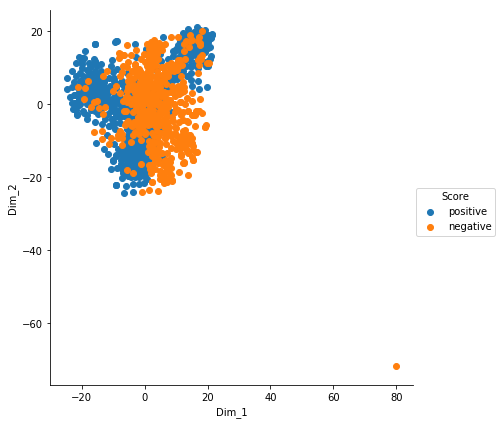

In [272]:
#Calling the function  to plot for tsne
tsne_plot(tfidf_tsne, y)

## Avg_W2V: 

          1. W2V can take the semantic meaning of the words.
          2. W2V can convert each word into an vector.
          3. Avg_W2V means for each review vector should be (W2V(word1) + W2V(word2)--------+ W2V(wordn)/(total no.of words).

In [273]:
sen_words = []
for sent in X:
    sen_words.append(sent.split())

In [280]:
#Converting each word into vector
w2v = gensim.models.Word2Vec(sen_words,min_count=5,size=50, workers=4)

In [282]:
#fining w2v_words
w2v_words = list(w2v.wv.vocab)

In [292]:
#Avg_W2V for all Reviews
avg_w2vs = []
for sent in X:
    #initializing number of words
    n_words = 0
    #initializing vector of size of 50
    sent_vec = np.zeros(50)
    for word in sent.split():
        if word in w2v_words:
            #creating for each word is an vector
            vec = w2v.wv[word]
            sent_vec += vec
            n_words += 1
    if n_words != 0:
        sent_vec /= n_words
        avg_w2vs.append(sent_vec)

**TSNE: with perplexity=30 and no.of.iterations=1000**

In [295]:
#Running tsne with the default parameters are n_iterations=1000, perplexity=30
w2v_tsne = TSNE().fit_transform(avg_w2vs)

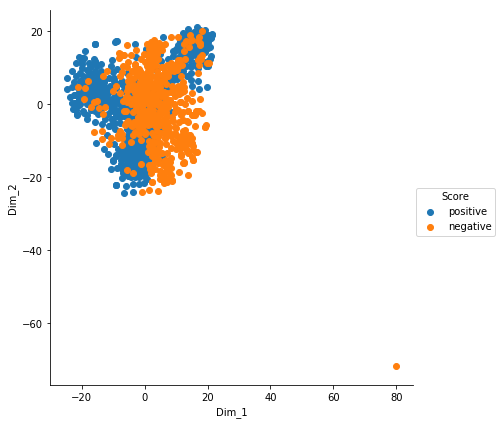

In [296]:
#Calling the function  to plot for tsne
tsne_plot(w2v_tsne, y)

**perplexity=40 and no.of.iterations=2000**

In [297]:
#Running tsne with the default parameters are n_iterations=2000, perplexity=40
w2v_tsne = TSNE(perplexity=40, n_iter=2000).fit_transform(avg_w2vs)

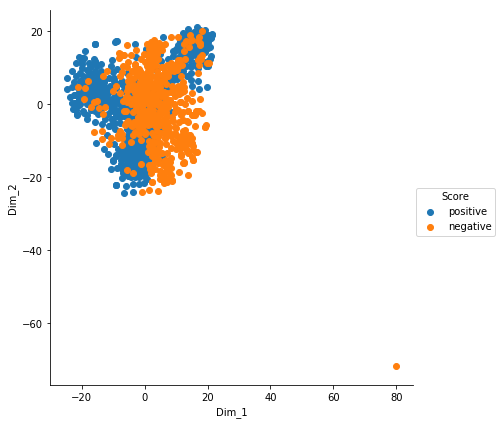

In [298]:
#Calling the function  to plot for tsne
tsne_plot(w2v_tsne, y)

**perplexity=20 and number of iterations=5000**

In [299]:
#Running tsne with the default parameters are n_iterations=5000, perplexity=20
w2v_tsne = TSNE(perplexity=20, n_iter=5000).fit_transform(avg_w2vs)

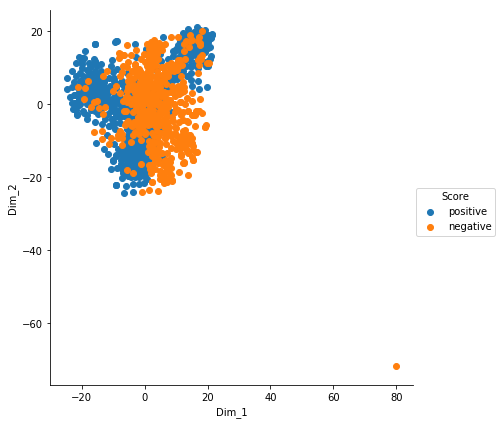

In [300]:
#Calling the function  to plot for tsne
tsne_plot(w2v_tsne, y)

## TFIDF-W2V:

In [304]:
#TFIDF_W2V for all reviews
features = tfidf_vect.get_feature_names()
tfidf_w2vs = []
row = 0
for sent in X:
    sent_vec = np.zeros(50)
    tfidf_sum = 0
    for word in sent.split():
        if(word in w2v_words):
            vec = w2v.wv[word]
            tfidf_value = tfidf[row, features.index(word)]
            sent_vec += (vec * tfidf_value)
            tfidf_sum += tfidf_value
    if(tfidf_sum != 0):
        sent_vec /= tfidf_sum
        tfidf_w2vs.append(sent_vec)
    row += 1

**TSNE: perplexity=30 and number of iterations=1000**

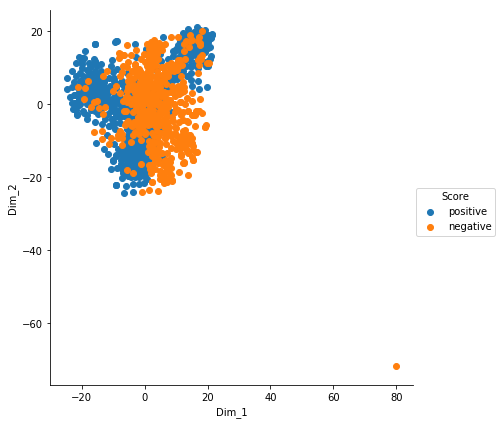

In [307]:
tfidf_w2vs_tsne = TSNE().fit_transform(tfidf_w2vs)

#Calling the function to plot the tsne plot
tsne_plot(tfidf_w2vs_tsne, y)

**perplexity=40 and number of iterations = 2000 **

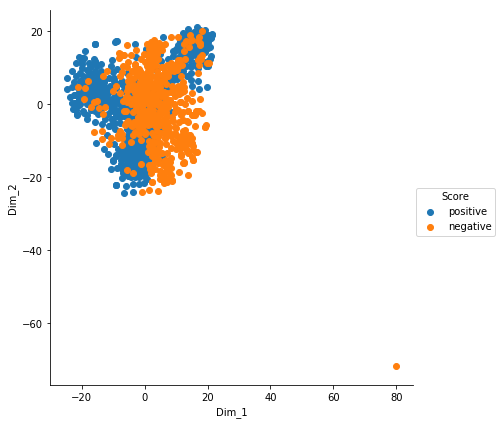

In [308]:
tfidf_w2vs_tsne = TSNE(perplexity=40, n_iter=2000).fit_transform(tfidf_w2vs)

#Calling the function to plot the tsne plot
tsne_plot(tfidf_w2vs_tsne, y)

**perplexity=20 and number of iterations=5000**

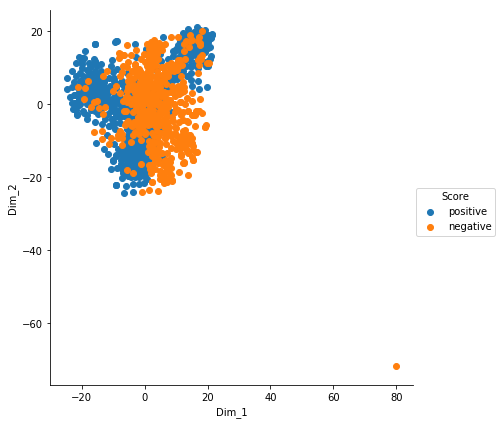

In [309]:
tfidf_w2vs_tsne = TSNE(perplexity=20, n_iter=5000).fit_transform(tfidf_w2vs)

#Calling the function to plot the tsne plot
tsne_plot(tfidf_w2vs_tsne, y)